# FCIQMC (Full Configuration Interaction Quantum Monte Carlo)

論文 [Fermion Monte Carlo without fixed nodes: A game of life, death, and
annihilation in Slater determinant space](https://2024.sci-hub.st/1534/f26924b07d1005f6f9a7be1b525feec7/booth2009.pdf) を読み、Pythonでの実装を試みる。

## 準備

```
$ conda install tqdm pandas
$ conda install -c conda-forge pyscf
```

## 共通の関数を定義

In [91]:
import numpy as np
import math
import matplotlib.pyplot as plt
from tqdm import tqdm
from collections import defaultdict
from pyscf import gto, scf, fci, ao2mo
import random

rng = np.random.default_rng()

def build_hamiltonian(mol):
    E_nuc = mol.energy_nuc()
    # print("E_nuc:", E_nuc)
    elec_num = sum(mol.nelec)
    myhf = mol.HF()
    myhf.kernel()
    mymp2 = myhf.MP2()
    mymp2.kernel() # run mp2
    C = myhf.mo_coeff # molecular coefficient matrix
    h1 = np.matmul((C.T),np.matmul((myhf.get_hcore()),(C)))
    h2 = ao2mo.kernel(mol,C)
    h2 = ao2mo.restore(8,h2,mol.nao_nr())

    H_mat = fci.direct_spin1.pspace(h1, h2, mol.nao_nr(), elec_num, np=70000)[1] # creates Hamiltonian
    H_mat = H_mat + E_nuc * np.eye(H_mat.shape[0])
    nspatorbs = int(mol.nao_nr())

    # --- フル FCI エネルギー ---
    cis = fci.FCI(myhf)
    E_fci, civec = cis.kernel(h1, h2, C.shape[1], mol.nelec)
    E_HF = myhf.e_tot

    return H_mat, E_fci, E_HF

# mol = gto.M(atom='H 0 0 0; H 0 0 0.74', basis='sto-3g', verbose=0)
# H_mat, E_fci, E_HF = build_hamiltonian(mol)
# print(H_mat)


def FCIQMC(mol, shift=0, init_n_walker=1, n_steps=5000, step_starting_shift_upd=500, n_prod=2500,
           shift_upd_interval=10, dt=0.001, damping=0.05, debug=True):
    """
    Full Configuration Interaction Quantum Monte Carlo (FCIQMC) を用いて基底状態エネルギーを推定する。

    Args:
        mol: PySCFのMoleculeオブジェクト
        shift: 初期シフト値 S(0)。ウォーカー数の増減を抑制するためのエネルギー的バイアス
        init_n_walker: 初期状態（参照決定基）に配置するウォーカー数
        n_steps: シミュレーションの総ステップ数
        step_starting_shift_upd: Shift の更新を開始するステップ。初期緩和期間としてこのステップまでは shift を固定する。
        shift_upd_interval: Shift をどの頻度で更新するか（ステップ単位）。例えば 10 なら、10 ステップごとに shift を更新する。
        n_prod: E_projの平均を計算するステップ数（処理完了時からこのステップ数遡って平均を取る）
        dt: imaginary time step（時間刻み）。小さいほど安定するが計算コストが増える
        damping: Shift更新時の更新の程度表すパラメータ
        debug: デバッグモード
        

    Returns:
        tuple:
            - **E_est (float)**: 最終 1000 ステップの projected energy の平均（推定エネルギー）
            - **hist_population (list[int])**: 各ステップのウォーカー総数の履歴
            - **hist_shift (list[float])**: 各ステップの shift の履歴
            - **hist_energy (list[float])**: 各ステップの projected energy の履歴
    """    
    H_mat, E_fci, E_HF = build_hamiltonian(mol)
    # H_mat = np.array([
    #     [-1.13727,  0.0,      0.18129, -0.18129,  0.0,      0.0     ],
    #     [ 0.0,     -0.51055,  0.0,      0.0,      0.0,      0.0     ],
    #     [ 0.18129,  0.0,     -0.67894,  0.0,      0.0,      0.18129 ],
    #     [-0.18129,  0.0,      0.0,     -0.67894,  0.0,     -0.18129 ],
    #     [ 0.0,      0.0,      0.0,      0.0,     -0.51055,  0.0     ],
    #     [ 0.0,      0.0,      0.18129, -0.18129,  0.0,     -0.16889]
    # ])
    # E_HF = H_mat[0, 0]
    print(f"--- FCI Matrix ---")
    print(H_mat.shape)
    print(H_mat)
    

    # print('E_HF:', E_HF)
    H_mat = H_mat - np.eye(H_mat.shape[0]) * E_HF
    print(f"--- K Matrix ---")
    print(H_mat)
    
    E_est = 0
    hist_population, hist_shift, hist_energy = [], [], []
    
    diag_H = np.diag(H_mat)    
    pre_shift = shift
    pre_pop = init_n_walker

    # 基底状態（Hartree-Fock解）のインデックスを特定
    # PySCFのFCIでは通常、最初の行列要素がHF状態に対応します
    ref_det_idx = 0 
        
    # ウォーカーの初期化 {det_index: signed_population}
    # 符号付き整数で管理（+1, -1など）
    walkers = {ref_det_idx: init_n_walker}

    print('\n---- Initial walkers ----')
    for k, v in walkers.items():
        tqdm.write(f"{v} walkers on {k}th determinant")

    
    for step in tqdm(range(n_steps), disable=(not debug)):
        new_walkers = defaultdict(int)
        
        # walkersが乗っている行列式の全てのインデックスを取得
        current_dets = list(walkers.keys())
        # if step % 1000 == 0:
        #     tqdm.write(f"current_dets: {current_dets}")

        
        for i in current_dets:
            n_i = walkers[i] # ith行列式上のウォーカー数（符号付き）
            if n_i == 0: continue

            # ----- Spawning Step -----
            row = H_mat[i]
            # 非ゼロ要素のインデックスを取得
            connected_dets = np.where(row != 0)[0]
            # 対角要素は自分自身への遷移を表すので処理しない
            connected_dets = connected_dets[connected_dets != i]
            # ランダムに遷移先determinant jを候補に選ぶ
            j = np.random.choice(connected_dets)
            h_ij = row[j]

            # Spawning probability: Ps = dt * |H_ij|
            # 生成される数: sign(walker) * sign(-H_ij)
            p_gen = 1/len(connected_dets)
            prob_spawn = dt * abs(h_ij) / p_gen

            # 全てのwalkerに対して、spawnを試みる
            n_spawn = np.full(abs(n_i), 0)
            prob_spawn_frac, prob_spawn_int = math.modf(prob_spawn)
            if prob_spawn_int > 1:
                n_spawn = np.full(abs(n_i), prob_spawn_int)
            n_spawn += (np.random.rand(abs(n_i)) <= prob_spawn).astype(int)
            
            # h_ij>0ならば親と異符号、h_ij<0ならば親と同符号のwalkerを遷移先jth行列式の上に生成
            if h_ij > 0:
                new_walkers[j] += -np.sign(n_i) * np.sum(n_spawn)
            else:
                new_walkers[j] += np.sign(n_i) * np.sum(n_spawn)


            # ----- Diagonal Step (Death/Cloning) -----
            # Pd = exp(-dt * (H_ii - S)) - 1  ~ -dt * (H_ii - S)
            h_ii = diag_H[i]
            prob_death = dt * (h_ii - shift)
            n_walker_on_D = n_i
            sign = np.sign(n_walker_on_D)

            # prob_deathの確率でdeath/cloneする（対象となるwalkerの数をカウントする）
            count = np.sum(np.random.rand(abs(n_i)) <= abs(prob_death))
            if prob_death > 0:
                # prob_deathが正ならwalkerをcount分消滅させる
                n_walker_on_D = sign * (abs(n_walker_on_D) - count)
            else:
                # prob_deathが負ならwalkerをcount分複製する
                n_walker_on_D = sign * (abs(n_walker_on_D) + count)    
            walkers[i] = n_walker_on_D
            

        # ----- Annihilation Step -----
        for idx, n in new_walkers.items():
            walkers[idx] = walkers.get(idx, 0) + n

        # ---- Shift Update -----
        current_pop = sum(abs(w) for w in walkers.values())
        if step > step_starting_shift_upd: # 初期緩和後
            if step % shift_upd_interval == 0:
                shift = pre_shift - (damping / (shift_upd_interval*dt)) * np.log(current_pop / pre_pop)
                pre_shift = shift
        hist_shift.append(shift)
        pre_pop = current_pop
        hist_population.append(current_pop)
        
        # ----- Energy Estimation (Projected Energy) -----
        # E_HF2 = diag_H[ref_det_idx]  # これはE_HFではない
        row0 = H_mat[ref_det_idx]
        num_ref = walkers.get(ref_det_idx, 0)

        # 論文では、singles/doublesに限定して合計している
        # この実装だとそもそもFCI行列の成分がsingles/doubles以外が0になっているので、
        # 全部を合計していて、結局singles/doublesだけが合計されることになっている
        E_proj = E_HF + sum(row0[idx]*v/num_ref for idx, v in walkers.items() if idx != ref_det_idx)
        
        # 生成したコードでは論文にはない項を足していた
        # これはハミルトニアンに各反発エネルギーが含まれているかいないかの解釈が論文と異なっているため？
        # これを含めなければ近い値に収束するので、コメントアウトしておく
        # E_proj += mol.energy_nuc()
        hist_energy.append(E_proj)
        
        if step % 1000 == 0 and debug:
            tqdm.write(f"Step {step}: Walkers={current_pop}, Shift={shift:.5f}, E_proj={E_proj:.6f}")
            for k, v in walkers.items():
                if v != 0:
                    tqdm.write(f"  {v} walkers on {k}th determinant")
    
    # n_prod件のhist_energyデータを10分割して平均を取り、標準偏差を求める
    n_block = 10
    hist_energy_prod = np.array(hist_energy[-n_prod:])
    block_size = len(hist_energy_prod) // n_block
    hist_energy_prod = hist_energy_prod[:n_block * block_size]  # 小数分を切り捨てる
    blocks = hist_energy_prod.reshape(n_block, block_size)
    block_means = blocks.mean(axis=1)
    E_sd = np.std(block_means, ddof=1)
    E_est = np.mean(block_means)
    
    # E_est = np.mean(hist_energy_prod) # 最後のn_prodステップの平均
    avg_shift = np.mean(hist_shift[-n_prod:]) # 最後のn_prodステップの平均

    
    print('\n---- Walkers (result) ----')
    for k, v in walkers.items():
        if v != 0:
            print(f"{v} walkers on {k}th determinant")

    return E_est, E_sd, E_fci, E_HF, avg_shift, hist_population, hist_shift, hist_energy


def plot_result(E_fci, E_HF, hist_population, hist_shift, hist_energy):
    plt.figure(figsize=(10, 6))
    plt.plot(hist_population)
    plt.xlabel('Step')
    plt.ylabel('Population')
    plt.yscale('log')

    E_corr = np.full_like(hist_shift, E_fci - E_HF)
    plt.figure(figsize=(10, 6))
    plt.plot(hist_shift, label="Shift")
    plt.plot(E_corr, linestyle="--", label=r"${E_{corr}}$")
    plt.xlabel('Step')
    plt.ylabel('Shift')
    plt.legend()

    E_fci_arr = np.full_like(hist_energy, E_fci)
    plt.figure(figsize=(10, 6))
    plt.plot(hist_energy, label=r"${E_{proj}}$")
    plt.plot(E_fci_arr, linestyle="--", label=r"${E_{FCI}}$")
    plt.xlabel('Step')
    plt.ylabel('Projected Energy')
    plt.legend()
    
    plt.show()

## ${H_2}$ 分子 STO-3G

FCIによる基底エネルギーは -1.1373 で、FCIQMCによる推定基底エネルギーは近い値が出る

--- FCI Matrix ---
(4, 4)
[[-1.11675931e+00 -3.63850793e-16 -3.63850793e-16  1.81210462e-01]
 [-3.63850793e-16 -3.49562895e-01  1.81210462e-01  1.90003444e-16]
 [-3.63850793e-16  1.81210462e-01 -3.49562895e-01  1.90003444e-16]
 [ 1.81210462e-01  1.90003444e-16  1.90003444e-16  4.62618146e-01]]
--- K Matrix ---
[[ 0.00000000e+00 -3.63850793e-16 -3.63850793e-16  1.81210462e-01]
 [-3.63850793e-16  7.67196412e-01  1.81210462e-01  1.90003444e-16]
 [-3.63850793e-16  1.81210462e-01  7.67196412e-01  1.90003444e-16]
 [ 1.81210462e-01  1.90003444e-16  1.90003444e-16  1.57937745e+00]]

---- Initial walkers ----
1 walkers on 0th determinant


 12%|██████████▋                                                                               | 3547/30000 [00:00<00:00, 35465.81it/s]

Step 0: Walkers=1, Shift=0.70000, E_proj=-1.116759
  1 walkers on 0th determinant
Step 1000: Walkers=2, Shift=0.70000, E_proj=-1.116759
  2 walkers on 0th determinant
Step 2000: Walkers=2, Shift=0.70000, E_proj=-1.116759
  2 walkers on 0th determinant
Step 3000: Walkers=3, Shift=0.70000, E_proj=-1.116759
  3 walkers on 0th determinant
Step 4000: Walkers=5, Shift=0.70000, E_proj=-1.116759
  5 walkers on 0th determinant
Step 5000: Walkers=8, Shift=0.70000, E_proj=-1.116759
  8 walkers on 0th determinant
Step 6000: Walkers=18, Shift=0.70000, E_proj=-1.116759
  18 walkers on 0th determinant
Step 7000: Walkers=44, Shift=0.70000, E_proj=-1.145371
  38 walkers on 0th determinant
  -6 walkers on 3th determinant


 36%|███████████████████████████████▊                                                         | 10719/30000 [00:00<00:00, 25580.24it/s]

Step 8000: Walkers=89, Shift=0.70000, E_proj=-1.134657
  81 walkers on 0th determinant
  -8 walkers on 3th determinant
Step 9000: Walkers=195, Shift=0.70000, E_proj=-1.147142
  167 walkers on 0th determinant
  -28 walkers on 3th determinant
Step 10000: Walkers=379, Shift=0.70000, E_proj=-1.141791
  333 walkers on 0th determinant
  -46 walkers on 3th determinant
Step 11000: Walkers=678, Shift=0.40810, E_proj=-1.140659
  599 walkers on 0th determinant
  -79 walkers on 3th determinant


 45%|████████████████████████████████████████▏                                                | 13535/30000 [00:00<00:00, 23688.51it/s]

Step 12000: Walkers=916, Shift=0.19698, E_proj=-1.133155
  840 walkers on 0th determinant
  -76 walkers on 3th determinant
Step 13000: Walkers=1098, Shift=0.13583, E_proj=-1.134917
  998 walkers on 0th determinant
  -100 walkers on 3th determinant
Step 14000: Walkers=1238, Shift=0.06196, E_proj=-1.137474
  1111 walkers on 0th determinant
  -127 walkers on 3th determinant
Step 15000: Walkers=1279, Shift=-0.00108, E_proj=-1.134662
  1164 walkers on 0th determinant
  -115 walkers on 3th determinant
Step 16000: Walkers=1280, Shift=-0.01657, E_proj=-1.133966
  1169 walkers on 0th determinant
  -111 walkers on 3th determinant


 69%|█████████████████████████████████████████████████████████████▏                           | 20632/30000 [00:00<00:00, 21182.25it/s]

Step 17000: Walkers=1307, Shift=-0.02433, E_proj=-1.136093
  1181 walkers on 0th determinant
  -126 walkers on 3th determinant
Step 18000: Walkers=1279, Shift=-0.03191, E_proj=-1.136388
  1154 walkers on 0th determinant
  -125 walkers on 3th determinant
Step 19000: Walkers=1262, Shift=-0.02785, E_proj=-1.136858
  1136 walkers on 0th determinant
  -126 walkers on 3th determinant
Step 20000: Walkers=1273, Shift=0.02357, E_proj=-1.135793
  1152 walkers on 0th determinant
  -121 walkers on 3th determinant


 76%|███████████████████████████████████████████████████████████████████▌                     | 22780/30000 [00:01<00:00, 20547.46it/s]

Step 21000: Walkers=1356, Shift=0.00478, E_proj=-1.140659
  1198 walkers on 0th determinant
  -158 walkers on 3th determinant
Step 22000: Walkers=1361, Shift=0.01581, E_proj=-1.135086
  1236 walkers on 0th determinant
  -125 walkers on 3th determinant
Step 23000: Walkers=1434, Shift=0.00912, E_proj=-1.136210
  1295 walkers on 0th determinant
  -139 walkers on 3th determinant
Step 24000: Walkers=1463, Shift=-0.01148, E_proj=-1.137001
  1316 walkers on 0th determinant
  -147 walkers on 3th determinant


 89%|███████████████████████████████████████████████████████████████████████████████▋         | 26844/30000 [00:01<00:00, 19417.51it/s]

Step 25000: Walkers=1451, Shift=-0.01160, E_proj=-1.134291
  1323 walkers on 0th determinant
  -128 walkers on 3th determinant
Step 26000: Walkers=1479, Shift=-0.03539, E_proj=-1.140763
  1306 walkers on 0th determinant
  -173 walkers on 3th determinant
Step 27000: Walkers=1444, Shift=-0.01458, E_proj=-1.138235
  1291 walkers on 0th determinant
  -153 walkers on 3th determinant
Step 28000: Walkers=1449, Shift=0.02017, E_proj=-1.135681
  1312 walkers on 0th determinant
  -137 walkers on 3th determinant


100%|█████████████████████████████████████████████████████████████████████████████████████████| 30000/30000 [00:01<00:00, 21665.39it/s]


Step 29000: Walkers=1477, Shift=-0.00344, E_proj=-1.133367
  1353 walkers on 0th determinant
  -124 walkers on 3th determinant

---- Walkers (result) ----
1354 walkers on 0th determinant
-136 walkers on 3th determinant
E_fci=-1.137283834488502, E_HF=-1.1167593073964248
------------------------------
FCI Energy: -1.137284 Ha
Final FCIQMC Energy: -1.136980 ±  0.001920 Ha
Average shift: -0.005328 Ha => Energy: -1.1220874455744143


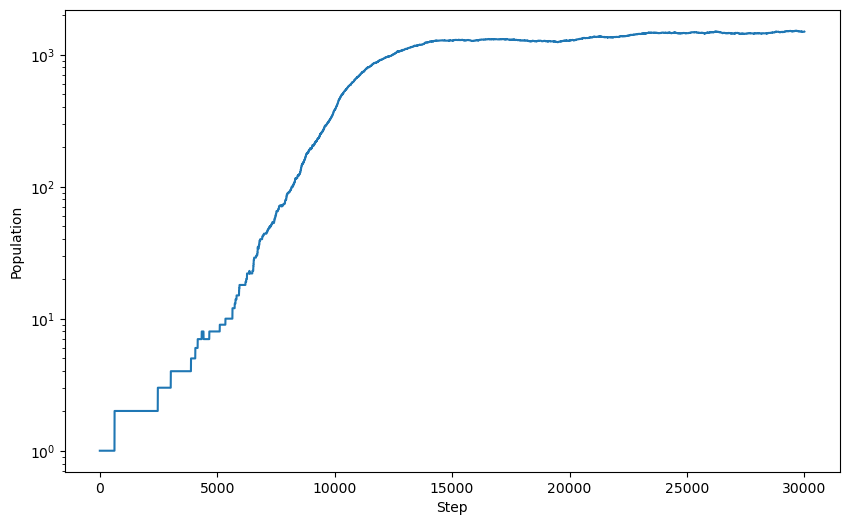

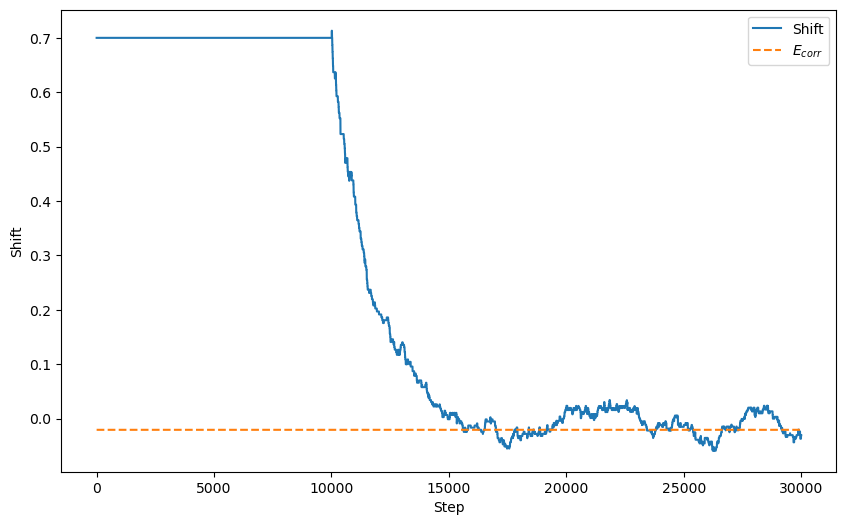

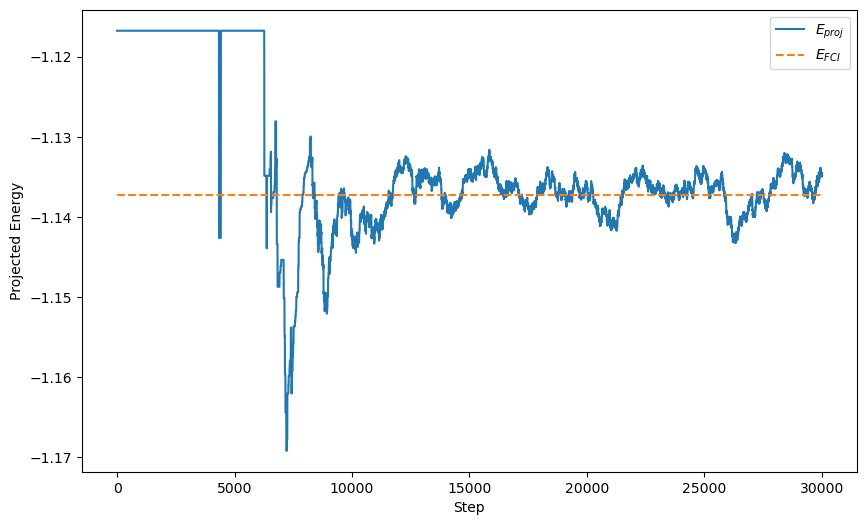

In [116]:
from pyscf import gto

# H2分子の定義 (0.74 Angstrom)
mol = gto.M(atom='H 0 0 0; H 0 0 0.74', basis='sto-3g', verbose=0)
E_est, E_sd, E_fci, E_HF, avg_shift, hist_population, hist_shift, hist_energy = \
    FCIQMC(mol, shift=0.7, init_n_walker=1, n_steps=30000, n_prod=10000, step_starting_shift_upd=10000)

print(f"E_fci={E_fci}, E_HF={E_HF}")

# 結果を出力
print("-" * 30)
print(f"FCI Energy: {E_fci:.6f} Ha")
print(f"Final FCIQMC Energy: {E_est:.6f} ± {E_sd: .6f} Ha")
print(f"Average shift: {avg_shift:.6f} Ha => Energy: {avg_shift + E_HF}")
plot_result(E_fci, E_HF, hist_population, hist_shift, hist_energy)


## ${H_3^+}$ (sto-3g)
FCI行列は9x9

converged SCF energy = -1.24591513197544
E(RMP2) = -1.26559786762945  E_corr = -0.0196827356540126
E(SCS-RMP2) = -1.26953441476026  E_corr = -0.0236192827848151
--- FCI Matrix ---
(9, 9)
[[-1.24591513e+00  2.78282448e-17 -9.82897130e-09  2.78282448e-17
   1.44076448e-01 -4.65022949e-17 -9.82897130e-09 -4.65022949e-17
   1.44076569e-01]
 [ 2.78282448e-17 -6.16148605e-01 -4.94150488e-17  1.44076448e-01
   2.23904423e-12 -9.56437226e-02 -4.65022949e-17 -9.56440818e-02
  -2.23896578e-12]
 [-9.82897130e-09 -4.94150488e-17 -6.16130888e-01 -4.65022949e-17
  -9.56437226e-02 -2.23892764e-12  1.44076569e-01 -2.23896578e-12
   9.56396165e-02]
 [ 2.78282448e-17  1.44076448e-01 -4.65022949e-17 -6.16148605e-01
   2.23904423e-12 -9.56440818e-02 -4.94150488e-17 -9.56437226e-02
  -2.23896578e-12]
 [ 1.44076448e-01  2.23904423e-12 -9.56437226e-02  2.23904423e-12
   1.13702477e-01 -3.38168990e-16 -9.56437226e-02 -3.38168990e-16
   7.58871399e-02]
 [-4.65022949e-17 -9.56437226e-02 -2.23892764e-12 -9.56440

 14%|████████████▍                                                                             | 2763/20000 [00:00<00:00, 27617.38it/s]

Step 0: Walkers=1, Shift=0.80000, E_proj=-1.245915
  1 walkers on 0th determinant
Step 1000: Walkers=3, Shift=0.80000, E_proj=-1.245915
  3 walkers on 0th determinant
Step 2000: Walkers=5, Shift=0.80000, E_proj=-1.245915
  5 walkers on 0th determinant
Step 3000: Walkers=31, Shift=0.80000, E_proj=-1.310750
  20 walkers on 0th determinant
  -1 walkers on 2th determinant
  -6 walkers on 4th determinant
  -1 walkers on 6th determinant
  -3 walkers on 8th determinant


 28%|████████████████████████▊                                                                 | 5525/20000 [00:00<00:01, 13919.89it/s]

Step 4000: Walkers=55, Shift=0.80000, E_proj=-1.285536
  40 walkers on 0th determinant
  -8 walkers on 4th determinant
  -4 walkers on 6th determinant
  -3 walkers on 8th determinant
Step 5000: Walkers=118, Shift=0.80000, E_proj=-1.287798
  86 walkers on 0th determinant
  1 walkers on 2th determinant
  -15 walkers on 4th determinant
  -6 walkers on 6th determinant
  -10 walkers on 8th determinant
Step 6000: Walkers=242, Shift=0.80000, E_proj=-1.276843
  191 walkers on 0th determinant
  -2 walkers on 2th determinant
  -25 walkers on 4th determinant
  -8 walkers on 6th determinant
  -16 walkers on 8th determinant


 43%|██████████████████████████████████████▊                                                   | 8628/20000 [00:00<00:01, 11232.45it/s]

Step 7000: Walkers=507, Shift=0.80000, E_proj=-1.266403
  436 walkers on 0th determinant
  -2 walkers on 2th determinant
  -32 walkers on 4th determinant
  -7 walkers on 6th determinant
  -30 walkers on 8th determinant
Step 8000: Walkers=1173, Shift=0.80000, E_proj=-1.272471
  982 walkers on 0th determinant
  -1 walkers on 2th determinant
  -99 walkers on 4th determinant
  -9 walkers on 6th determinant
  -82 walkers on 8th determinant


 49%|████████████████████████████████████████████▎                                             | 9853/20000 [00:00<00:01, 10073.46it/s]

Step 9000: Walkers=2686, Shift=0.80000, E_proj=-1.272383
  2259 walkers on 0th determinant
  -3 walkers on 2th determinant
  -181 walkers on 4th determinant
  -9 walkers on 6th determinant
  -234 walkers on 8th determinant
Step 10000: Walkers=6175, Shift=0.80000, E_proj=-1.274244
  5152 walkers on 0th determinant
  2 walkers on 2th determinant
  -459 walkers on 4th determinant
  8 walkers on 6th determinant
  -554 walkers on 8th determinant


 59%|█████████████████████████████████████████████████████▏                                    | 11817/20000 [00:01<00:01, 6958.62it/s]

Step 11000: Walkers=12054, Shift=0.49802, E_proj=-1.274486
  10030 walkers on 0th determinant
  15 walkers on 2th determinant
  -917 walkers on 4th determinant
  20 walkers on 6th determinant
  -1072 walkers on 8th determinant


 63%|████████████████████████████████████████████████████████▌                                 | 12564/20000 [00:01<00:01, 5772.48it/s]

Step 12000: Walkers=18239, Shift=0.27219, E_proj=-1.274795
  15186 walkers on 0th determinant
  4 walkers on 2th determinant
  -1645 walkers on 4th determinant
  -5 walkers on 6th determinant
  -1399 walkers on 8th determinant


 66%|███████████████████████████████████████████████████████████▎                              | 13186/20000 [00:01<00:01, 4955.59it/s]

Step 13000: Walkers=22909, Shift=0.14186, E_proj=-1.273392
  19197 walkers on 0th determinant
  47 walkers on 2th determinant
  -1958 walkers on 4th determinant
  -4 walkers on 6th determinant
  -1703 walkers on 8th determinant


 71%|███████████████████████████████████████████████████████████████▊                          | 14169/20000 [00:02<00:01, 3878.91it/s]

Step 14000: Walkers=26592, Shift=0.08691, E_proj=-1.275099
  22038 walkers on 0th determinant
  43 walkers on 2th determinant
  -2114 walkers on 4th determinant
  47 walkers on 6th determinant
  -2350 walkers on 8th determinant


 76%|████████████████████████████████████████████████████████████████████▋                     | 15269/20000 [00:02<00:01, 3141.78it/s]

Step 15000: Walkers=29253, Shift=0.01651, E_proj=-1.276032
  24149 walkers on 0th determinant
  -11 walkers on 2th determinant
  -2618 walkers on 4th determinant
  45 walkers on 6th determinant
  -2430 walkers on 8th determinant


 82%|█████████████████████████████████████████████████████████████████████████▉                | 16432/20000 [00:02<00:01, 2752.30it/s]

Step 16000: Walkers=30119, Shift=-0.00320, E_proj=-1.275456
  24913 walkers on 0th determinant
  -38 walkers on 2th determinant
  -2778 walkers on 4th determinant
  60 walkers on 6th determinant
  -2330 walkers on 8th determinant


 88%|██████████████████████████████████████████████████████████████████████████████▊           | 17500/20000 [00:03<00:00, 2634.89it/s]

Step 17000: Walkers=30185, Shift=-0.01282, E_proj=-1.272969
  25360 walkers on 0th determinant
  -51 walkers on 2th determinant
  -2484 walkers on 4th determinant
  12 walkers on 6th determinant
  -2278 walkers on 8th determinant


 92%|██████████████████████████████████████████████████████████████████████████████████▎       | 18305/20000 [00:03<00:00, 2531.17it/s]

Step 18000: Walkers=30865, Shift=-0.04630, E_proj=-1.275309
  25552 walkers on 0th determinant
  -64 walkers on 2th determinant
  -2456 walkers on 4th determinant
  36 walkers on 6th determinant
  -2757 walkers on 8th determinant


 97%|███████████████████████████████████████████████████████████████████████████████████████   | 19343/20000 [00:04<00:00, 2567.80it/s]

Step 19000: Walkers=30621, Shift=-0.00677, E_proj=-1.273760
  25628 walkers on 0th determinant
  15 walkers on 2th determinant
  -2623 walkers on 4th determinant
  -25 walkers on 6th determinant
  -2330 walkers on 8th determinant


100%|██████████████████████████████████████████████████████████████████████████████████████████| 20000/20000 [00:04<00:00, 4701.77it/s]



---- Walkers (result) ----
25721 walkers on 0th determinant
6 walkers on 2th determinant
-2559 walkers on 4th determinant
-17 walkers on 6th determinant
-2392 walkers on 8th determinant
------------------------------
FCI Energy: -1.274275 Ha
Final FCIQMC Energy: -1.274824 ±  0.000873 Ha
Average shift: 0.130721 Ha => Energy: -1.1151937009939108


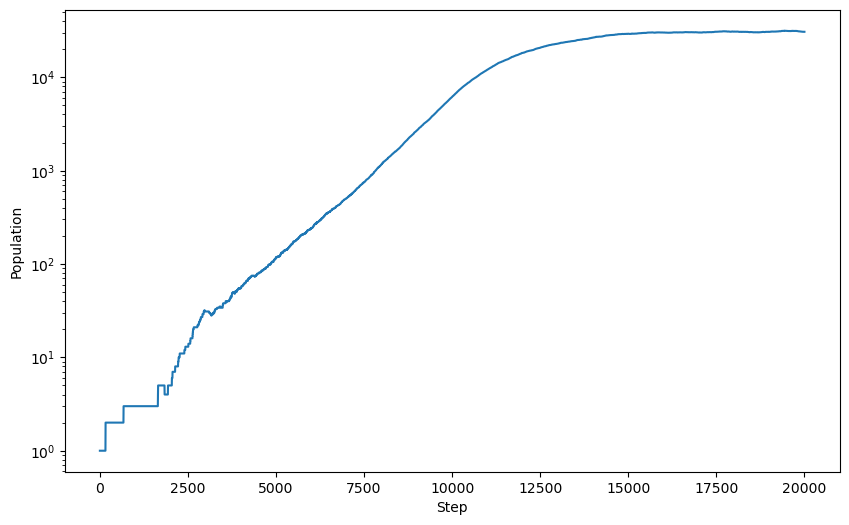

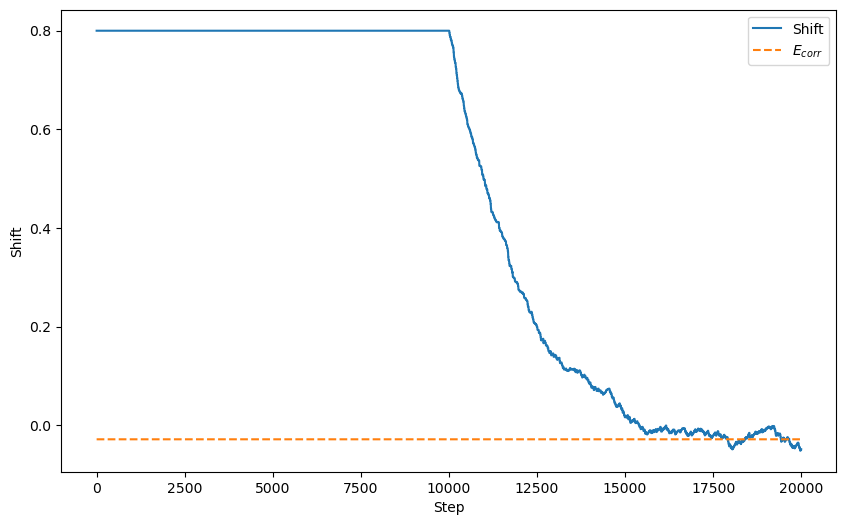

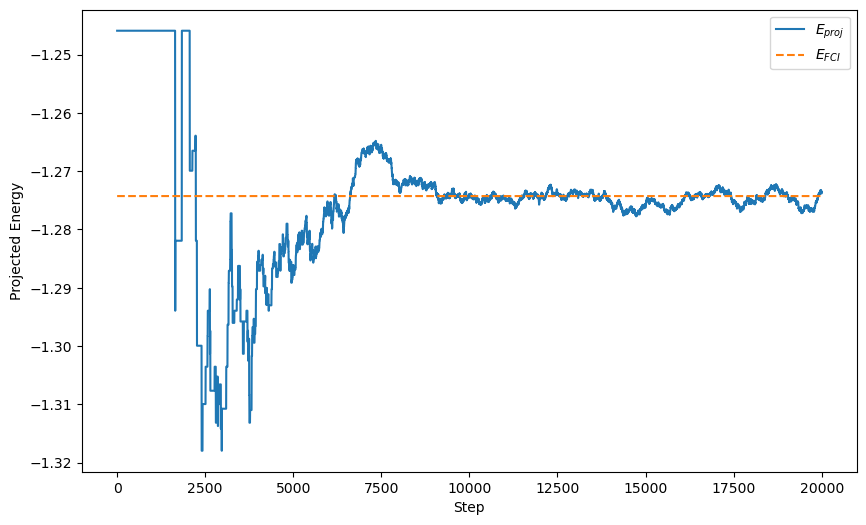

In [119]:
from pyscf import gto

# H3+分子の定義
mol = gto.M(
    atom = "H 0 0 0; H 1 0 0; H 0.5 0.866 0",
    basis = "sto-3g",
    charge = 1,
    spin = 0
)
E_est, E_sd, E_fci, E_HF, avg_shift, hist_population, hist_shift, hist_energy = \
    FCIQMC(mol, shift=0.8, n_steps=20000, n_prod=10000, step_starting_shift_upd=10000)

# 結果を出力
print("-" * 30)
print(f"FCI Energy: {E_fci:.6f} Ha")
print(f"Final FCIQMC Energy: {E_est:.6f} ± {E_sd: .6f} Ha")
print(f"Average shift: {avg_shift:.6f} Ha => Energy: {avg_shift + E_HF}")
plot_result(E_fci, E_HF, hist_population, hist_shift, hist_energy)


## ${LiH}$ (STO-3G)
FCI行列は225x225

--- FCI Matrix ---
(225, 225)
[[-7.86186477e+00  1.27143190e-08 -1.26874171e-10 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 1.27143190e-08 -7.70892352e+00 -1.12113377e-02 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [-1.26874171e-10 -1.12113377e-02 -5.80885774e+00 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 ...
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ... -1.46233425e+00
  -2.13430486e-17 -1.16033563e-17]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ... -2.13430486e-17
  -1.41526201e+00 -3.66296584e-17]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ... -1.16033563e-17
  -3.66296584e-17 -1.38152373e+00]]
--- K Matrix ---
[[-1.77635684e-15  1.27143190e-08 -1.26874171e-10 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 1.27143190e-08  1.52941253e-01 -1.12113377e-02 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [-1.26874171e-10 -1.12113377e-02  2.05300703e+00 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 .

  1%|█▎                                                                                          | 440/30000 [00:00<00:06, 4393.77it/s]

Step 0: Walkers=1, Shift=0.70000, E_proj=-7.861865
  1 walkers on 0th determinant
Step 1000: Walkers=9, Shift=0.70000, E_proj=-7.907077
  6 walkers on 0th determinant
  -2 walkers on 160th determinant
  -1 walkers on 96th determinant


 12%|██████████▉                                                                                | 3614/30000 [00:00<00:04, 5721.04it/s]

Step 2000: Walkers=14, Shift=0.70000, E_proj=-7.880809
  10 walkers on 0th determinant
  1 walkers on 97th determinant
  -1 walkers on 160th determinant
  -1 walkers on 96th determinant
  1 walkers on 151th determinant
Step 3000: Walkers=28, Shift=0.70000, E_proj=-7.882466
  22 walkers on 0th determinant
  -3 walkers on 160th determinant
  -2 walkers on 96th determinant
  1 walkers on 151th determinant


 16%|██████████████▎                                                                            | 4708/30000 [00:00<00:05, 4641.42it/s]

Step 4000: Walkers=65, Shift=0.70000, E_proj=-7.877263
  50 walkers on 0th determinant
  -4 walkers on 160th determinant
  -2 walkers on 96th determinant
  -1 walkers on 48th determinant
  2 walkers on 151th determinant
  3 walkers on 25th determinant
  -1 walkers on 32th determinant
  -1 walkers on 112th determinant
  -1 walkers on 40th determinant


 17%|███████████████▋                                                                           | 5187/30000 [00:01<00:06, 3878.79it/s]

Step 5000: Walkers=151, Shift=0.70000, E_proj=-7.880059
  107 walkers on 0th determinant
  -1 walkers on 2th determinant
  -1 walkers on 176th determinant
  -4 walkers on 16th determinant
  -11 walkers on 160th determinant
  -5 walkers on 96th determinant
  -4 walkers on 48th determinant
  4 walkers on 151th determinant
  5 walkers on 25th determinant
  3 walkers on 15th determinant
  3 walkers on 1th determinant
  1 walkers on 134th determinant
  1 walkers on 40th determinant
  -1 walkers on 162th determinant


 21%|███████████████████▏                                                                       | 6339/30000 [00:01<00:07, 3051.56it/s]

Step 6000: Walkers=326, Shift=0.70000, E_proj=-7.880325
  229 walkers on 0th determinant
  2 walkers on 49th determinant
  1 walkers on 97th determinant
  1 walkers on 26th determinant
  -11 walkers on 16th determinant
  -24 walkers on 160th determinant
  -1 walkers on 17th determinant
  -12 walkers on 96th determinant
  -6 walkers on 48th determinant
  -1 walkers on 167th determinant
  11 walkers on 151th determinant
  7 walkers on 25th determinant
  -2 walkers on 32th determinant
  1 walkers on 165th determinant
  8 walkers on 15th determinant
  6 walkers on 1th determinant
  -2 walkers on 198th determinant
  1 walkers on 181th determinant


 24%|█████████████████████▉                                                                     | 7227/30000 [00:01<00:10, 2117.30it/s]

Step 7000: Walkers=673, Shift=0.70000, E_proj=-7.881344
  458 walkers on 0th determinant
  -1 walkers on 64th determinant
  1 walkers on 152th determinant
  -1 walkers on 31th determinant
  -1 walkers on 2th determinant
  2 walkers on 97th determinant
  1 walkers on 26th determinant
  -1 walkers on 176th determinant
  -24 walkers on 16th determinant
  -47 walkers on 160th determinant
  -1 walkers on 175th determinant
  -20 walkers on 96th determinant
  -12 walkers on 48th determinant
  1 walkers on 167th determinant
  2 walkers on 111th determinant
  30 walkers on 151th determinant
  1 walkers on 30th determinant
  26 walkers on 25th determinant
  1 walkers on 165th determinant
  3 walkers on 63th determinant
  5 walkers on 10th determinant
  16 walkers on 15th determinant
  12 walkers on 1th determinant
  -2 walkers on 112th determinant
  1 walkers on 166th determinant
  -1 walkers on 104th determinant
  -1 walkers on 198th determinant
  -1 walkers on 182th determinant


 27%|████████████████████████▉                                                                  | 8211/30000 [00:02<00:13, 1630.16it/s]

Step 8000: Walkers=1292, Shift=0.70000, E_proj=-7.879681
  909 walkers on 0th determinant
  -1 walkers on 31th determinant
  3 walkers on 49th determinant
  6 walkers on 97th determinant
  2 walkers on 26th determinant
  -1 walkers on 176th determinant
  -34 walkers on 16th determinant
  -1 walkers on 12th determinant
  -87 walkers on 160th determinant
  -1 walkers on 17th determinant
  -31 walkers on 96th determinant
  -38 walkers on 48th determinant
  2 walkers on 167th determinant
  1 walkers on 111th determinant
  52 walkers on 151th determinant
  1 walkers on 30th determinant
  39 walkers on 25th determinant
  -2 walkers on 32th determinant
  6 walkers on 63th determinant
  3 walkers on 10th determinant
  28 walkers on 15th determinant
  27 walkers on 1th determinant
  -2 walkers on 112th determinant
  4 walkers on 166th determinant
  -2 walkers on 104th determinant
  -2 walkers on 98th determinant
  1 walkers on 144th determinant
  1 walkers on 27th determinant
  2 walkers on 162

 31%|███████████████████████████▉                                                               | 9215/30000 [00:03<00:16, 1229.84it/s]

Step 9000: Walkers=2280, Shift=0.38137, E_proj=-7.881800
  1589 walkers on 0th determinant
  -6 walkers on 64th determinant
  2 walkers on 161th determinant
  2 walkers on 152th determinant
  6 walkers on 49th determinant
  -2 walkers on 2th determinant
  4 walkers on 97th determinant
  -1 walkers on 176th determinant
  -36 walkers on 16th determinant
  2 walkers on 12th determinant
  -179 walkers on 160th determinant
  -50 walkers on 96th determinant
  -43 walkers on 48th determinant
  2 walkers on 180th determinant
  2 walkers on 167th determinant
  15 walkers on 111th determinant
  106 walkers on 151th determinant
  76 walkers on 25th determinant
  -11 walkers on 32th determinant
  2 walkers on 150th determinant
  1 walkers on 165th determinant
  3 walkers on 63th determinant
  5 walkers on 10th determinant
  54 walkers on 15th determinant
  58 walkers on 1th determinant
  -2 walkers on 216th determinant
  -2 walkers on 112th determinant
  2 walkers on 166th determinant
  -1 walkers

 34%|██████████████████████████████▍                                                           | 10125/30000 [00:04<00:16, 1216.84it/s]

Step 10000: Walkers=3160, Shift=0.18840, E_proj=-7.881444
  2173 walkers on 0th determinant
  -10 walkers on 64th determinant
  4 walkers on 152th determinant
  3 walkers on 49th determinant
  -2 walkers on 2th determinant
  15 walkers on 97th determinant
  -3 walkers on 176th determinant
  -62 walkers on 16th determinant
  1 walkers on 12th determinant
  -222 walkers on 160th determinant
  -76 walkers on 96th determinant
  -73 walkers on 48th determinant
  3 walkers on 41th determinant
  1 walkers on 180th determinant
  -1 walkers on 167th determinant
  11 walkers on 111th determinant
  140 walkers on 151th determinant
  1 walkers on 30th determinant
  155 walkers on 25th determinant
  -6 walkers on 32th determinant
  5 walkers on 150th determinant
  6 walkers on 63th determinant
  83 walkers on 15th determinant
  87 walkers on 1th determinant
  1 walkers on 224th determinant
  -2 walkers on 216th determinant
  -1 walkers on 119th determinant
  1 walkers on 166th determinant
  -1 walk

 37%|█████████████████████████████████▌                                                         | 11057/30000 [00:05<00:20, 923.33it/s]

Step 11000: Walkers=3859, Shift=0.08217, E_proj=-7.882074
  2585 walkers on 0th determinant
  -5 walkers on 64th determinant
  2 walkers on 161th determinant
  2 walkers on 152th determinant
  7 walkers on 49th determinant
  8 walkers on 97th determinant
  6 walkers on 26th determinant
  -5 walkers on 176th determinant
  1 walkers on 11th determinant
  -79 walkers on 16th determinant
  2 walkers on 12th determinant
  -270 walkers on 160th determinant
  4 walkers on 17th determinant
  -76 walkers on 96th determinant
  -117 walkers on 48th determinant
  3 walkers on 180th determinant
  1 walkers on 167th determinant
  10 walkers on 111th determinant
  154 walkers on 151th determinant
  -1 walkers on 30th determinant
  208 walkers on 25th determinant
  -13 walkers on 32th determinant
  8 walkers on 150th determinant
  2 walkers on 165th determinant
  4 walkers on 63th determinant
  1 walkers on 10th determinant
  116 walkers on 15th determinant
  117 walkers on 1th determinant
  -7 walker

 40%|████████████████████████████████████▎                                                     | 12101/30000 [00:06<00:17, 1030.12it/s]

Step 12000: Walkers=4050, Shift=0.05488, E_proj=-7.883372
  2752 walkers on 0th determinant
  1 walkers on 161th determinant
  1 walkers on 152th determinant
  10 walkers on 49th determinant
  1 walkers on 2th determinant
  8 walkers on 97th determinant
  5 walkers on 26th determinant
  -2 walkers on 176th determinant
  1 walkers on 11th determinant
  -94 walkers on 16th determinant
  3 walkers on 12th determinant
  -339 walkers on 160th determinant
  -62 walkers on 96th determinant
  -103 walkers on 48th determinant
  2 walkers on 180th determinant
  12 walkers on 111th determinant
  150 walkers on 151th determinant
  -1 walkers on 30th determinant
  181 walkers on 25th determinant
  -11 walkers on 32th determinant
  8 walkers on 150th determinant
  8 walkers on 63th determinant
  126 walkers on 15th determinant
  129 walkers on 1th determinant
  -7 walkers on 112th determinant
  1 walkers on 134th determinant
  4 walkers on 166th determinant
  -2 walkers on 126th determinant
  -2 wal

 44%|███████████████████████████████████████▊                                                   | 13119/30000 [00:07<00:17, 968.31it/s]

Step 13000: Walkers=4364, Shift=0.07533, E_proj=-7.882842
  2976 walkers on 0th determinant
  -9 walkers on 64th determinant
  1 walkers on 161th determinant
  3 walkers on 152th determinant
  2 walkers on 31th determinant
  9 walkers on 49th determinant
  1 walkers on 2th determinant
  6 walkers on 97th determinant
  4 walkers on 26th determinant
  -3 walkers on 176th determinant
  3 walkers on 11th determinant
  -99 walkers on 16th determinant
  1 walkers on 12th determinant
  -362 walkers on 160th determinant
  -1 walkers on 17th determinant
  2 walkers on 175th determinant
  -75 walkers on 96th determinant
  -84 walkers on 48th determinant
  1 walkers on 41th determinant
  2 walkers on 180th determinant
  1 walkers on 167th determinant
  13 walkers on 111th determinant
  157 walkers on 151th determinant
  -3 walkers on 30th determinant
  187 walkers on 25th determinant
  -9 walkers on 32th determinant
  12 walkers on 150th determinant
  2 walkers on 165th determinant
  4 walkers on

 47%|██████████████████████████████████████████▊                                                | 14099/30000 [00:08<00:17, 908.56it/s]

Step 14000: Walkers=4575, Shift=-0.00719, E_proj=-7.883937
  3075 walkers on 0th determinant
  -1 walkers on 64th determinant
  -1 walkers on 161th determinant
  1 walkers on 152th determinant
  5 walkers on 49th determinant
  1 walkers on 2th determinant
  19 walkers on 97th determinant
  1 walkers on 26th determinant
  -2 walkers on 176th determinant
  -132 walkers on 16th determinant
  2 walkers on 12th determinant
  -383 walkers on 160th determinant
  -2 walkers on 17th determinant
  -116 walkers on 96th determinant
  -49 walkers on 48th determinant
  3 walkers on 180th determinant
  -2 walkers on 167th determinant
  8 walkers on 111th determinant
  174 walkers on 151th determinant
  243 walkers on 25th determinant
  -1 walkers on 32th determinant
  14 walkers on 150th determinant
  2 walkers on 165th determinant
  5 walkers on 63th determinant
  6 walkers on 10th determinant
  139 walkers on 15th determinant
  143 walkers on 1th determinant
  -2 walkers on 216th determinant
  -5 w

 50%|█████████████████████████████████████████████▋                                             | 15048/30000 [00:09<00:16, 904.05it/s]

Step 15000: Walkers=4730, Shift=0.01877, E_proj=-7.882285
  3156 walkers on 0th determinant
  -11 walkers on 64th determinant
  2 walkers on 161th determinant
  1 walkers on 152th determinant
  2 walkers on 31th determinant
  19 walkers on 49th determinant
  7 walkers on 97th determinant
  3 walkers on 26th determinant
  2 walkers on 176th determinant
  2 walkers on 11th determinant
  -121 walkers on 16th determinant
  1 walkers on 12th determinant
  -341 walkers on 160th determinant
  2 walkers on 17th determinant
  1 walkers on 175th determinant
  -98 walkers on 96th determinant
  -60 walkers on 48th determinant
  4 walkers on 180th determinant
  -1 walkers on 167th determinant
  15 walkers on 111th determinant
  246 walkers on 151th determinant
  214 walkers on 25th determinant
  -21 walkers on 32th determinant
  15 walkers on 150th determinant
  3 walkers on 165th determinant
  9 walkers on 63th determinant
  10 walkers on 10th determinant
  164 walkers on 15th determinant
  148 wa

 54%|████████████████████████████████████████████████▉                                          | 16150/30000 [00:10<00:14, 974.38it/s]

Step 16000: Walkers=4922, Shift=0.04131, E_proj=-7.882871
  3299 walkers on 0th determinant
  -7 walkers on 64th determinant
  -1 walkers on 31th determinant
  11 walkers on 49th determinant
  8 walkers on 97th determinant
  2 walkers on 26th determinant
  -4 walkers on 176th determinant
  -150 walkers on 16th determinant
  1 walkers on 12th determinant
  -386 walkers on 160th determinant
  1 walkers on 175th determinant
  -78 walkers on 96th determinant
  -95 walkers on 48th determinant
  3 walkers on 41th determinant
  3 walkers on 180th determinant
  -4 walkers on 167th determinant
  14 walkers on 111th determinant
  186 walkers on 151th determinant
  -2 walkers on 30th determinant
  242 walkers on 25th determinant
  -5 walkers on 32th determinant
  19 walkers on 150th determinant
  2 walkers on 165th determinant
  9 walkers on 63th determinant
  11 walkers on 10th determinant
  176 walkers on 15th determinant
  142 walkers on 1th determinant
  -5 walkers on 216th determinant
  -11 

 57%|███████████████████████████████████████████████████▉                                       | 17109/30000 [00:11<00:13, 958.85it/s]

Step 17000: Walkers=4995, Shift=0.02910, E_proj=-7.877087
  3436 walkers on 0th determinant
  -8 walkers on 64th determinant
  -2 walkers on 161th determinant
  2 walkers on 31th determinant
  10 walkers on 49th determinant
  -1 walkers on 2th determinant
  12 walkers on 97th determinant
  5 walkers on 26th determinant
  -1 walkers on 176th determinant
  2 walkers on 11th determinant
  -174 walkers on 16th determinant
  2 walkers on 12th determinant
  -234 walkers on 160th determinant
  -3 walkers on 17th determinant
  1 walkers on 175th determinant
  -93 walkers on 96th determinant
  -88 walkers on 48th determinant
  5 walkers on 180th determinant
  8 walkers on 111th determinant
  215 walkers on 151th determinant
  249 walkers on 25th determinant
  -14 walkers on 32th determinant
  22 walkers on 150th determinant
  3 walkers on 165th determinant
  6 walkers on 63th determinant
  8 walkers on 10th determinant
  180 walkers on 15th determinant
  159 walkers on 1th determinant
  -4 walk

 60%|███████████████████████████████████████████████████████                                    | 18144/30000 [00:12<00:13, 899.37it/s]

Step 18000: Walkers=5078, Shift=-0.04511, E_proj=-7.876195
  3549 walkers on 0th determinant
  -15 walkers on 64th determinant
  3 walkers on 152th determinant
  1 walkers on 31th determinant
  7 walkers on 49th determinant
  3 walkers on 2th determinant
  6 walkers on 97th determinant
  -3 walkers on 176th determinant
  2 walkers on 11th determinant
  -168 walkers on 16th determinant
  1 walkers on 12th determinant
  -234 walkers on 160th determinant
  1 walkers on 17th determinant
  -89 walkers on 96th determinant
  -94 walkers on 48th determinant
  5 walkers on 41th determinant
  14 walkers on 111th determinant
  187 walkers on 151th determinant
  -2 walkers on 30th determinant
  240 walkers on 25th determinant
  -2 walkers on 32th determinant
  26 walkers on 150th determinant
  13 walkers on 63th determinant
  16 walkers on 10th determinant
  188 walkers on 15th determinant
  161 walkers on 1th determinant
  1 walkers on 224th determinant
  -3 walkers on 216th determinant
  -6 walk

 64%|█████████████████████████████████████████████████████████▎                                | 19118/30000 [00:13<00:10, 1012.14it/s]

Step 19000: Walkers=4932, Shift=-0.08255, E_proj=-7.880197
  3361 walkers on 0th determinant
  -1 walkers on 64th determinant
  3 walkers on 161th determinant
  1 walkers on 152th determinant
  -1 walkers on 31th determinant
  1 walkers on 49th determinant
  1 walkers on 2th determinant
  15 walkers on 97th determinant
  1 walkers on 26th determinant
  -1 walkers on 176th determinant
  1 walkers on 11th determinant
  -131 walkers on 16th determinant
  3 walkers on 12th determinant
  -312 walkers on 160th determinant
  5 walkers on 17th determinant
  1 walkers on 175th determinant
  -112 walkers on 96th determinant
  -96 walkers on 48th determinant
  -1 walkers on 41th determinant
  6 walkers on 180th determinant
  7 walkers on 111th determinant
  232 walkers on 151th determinant
  227 walkers on 25th determinant
  -6 walkers on 32th determinant
  16 walkers on 150th determinant
  1 walkers on 165th determinant
  11 walkers on 63th determinant
  13 walkers on 10th determinant
  186 walk

 67%|████████████████████████████████████████████████████████████▏                             | 20057/30000 [00:14<00:09, 1101.31it/s]

Step 20000: Walkers=4608, Shift=-0.09326, E_proj=-7.881713
  3142 walkers on 0th determinant
  -6 walkers on 64th determinant
  2 walkers on 152th determinant
  -1 walkers on 31th determinant
  16 walkers on 49th determinant
  1 walkers on 2th determinant
  6 walkers on 97th determinant
  -2 walkers on 176th determinant
  2 walkers on 11th determinant
  -132 walkers on 16th determinant
  3 walkers on 12th determinant
  -345 walkers on 160th determinant
  4 walkers on 17th determinant
  -85 walkers on 96th determinant
  -73 walkers on 48th determinant
  4 walkers on 167th determinant
  6 walkers on 111th determinant
  185 walkers on 151th determinant
  -1 walkers on 30th determinant
  194 walkers on 25th determinant
  -28 walkers on 32th determinant
  8 walkers on 150th determinant
  2 walkers on 165th determinant
  9 walkers on 63th determinant
  11 walkers on 10th determinant
  166 walkers on 15th determinant
  132 walkers on 1th determinant
  2 walkers on 224th determinant
  -9 walke

 70%|███████████████████████████████████████████████████████████████▎                          | 21120/30000 [00:15<00:08, 1007.43it/s]

Step 21000: Walkers=4465, Shift=-0.04810, E_proj=-7.879101
  3074 walkers on 0th determinant
  -5 walkers on 64th determinant
  1 walkers on 49th determinant
  6 walkers on 97th determinant
  3 walkers on 26th determinant
  -1 walkers on 176th determinant
  -133 walkers on 16th determinant
  1 walkers on 12th determinant
  -266 walkers on 160th determinant
  2 walkers on 175th determinant
  -81 walkers on 96th determinant
  -70 walkers on 48th determinant
  2 walkers on 180th determinant
  6 walkers on 111th determinant
  186 walkers on 151th determinant
  -1 walkers on 30th determinant
  224 walkers on 25th determinant
  -10 walkers on 32th determinant
  16 walkers on 150th determinant
  15 walkers on 63th determinant
  19 walkers on 10th determinant
  157 walkers on 15th determinant
  139 walkers on 1th determinant
  -2 walkers on 216th determinant
  -6 walkers on 112th determinant
  3 walkers on 134th determinant
  1 walkers on 217th determinant
  4 walkers on 166th determinant
  -1

 74%|███████████████████████████████████████████████████████████████████                        | 22090/30000 [00:16<00:08, 882.69it/s]

Step 22000: Walkers=4383, Shift=-0.00667, E_proj=-7.878159
  3034 walkers on 0th determinant
  -4 walkers on 64th determinant
  1 walkers on 161th determinant
  1 walkers on 31th determinant
  10 walkers on 49th determinant
  15 walkers on 97th determinant
  -2 walkers on 176th determinant
  2 walkers on 11th determinant
  -152 walkers on 16th determinant
  4 walkers on 12th determinant
  -249 walkers on 160th determinant
  1 walkers on 175th determinant
  -61 walkers on 96th determinant
  -82 walkers on 48th determinant
  4 walkers on 180th determinant
  1 walkers on 167th determinant
  12 walkers on 111th determinant
  167 walkers on 151th determinant
  1 walkers on 30th determinant
  194 walkers on 25th determinant
  -13 walkers on 32th determinant
  16 walkers on 150th determinant
  1 walkers on 165th determinant
  8 walkers on 63th determinant
  9 walkers on 10th determinant
  164 walkers on 15th determinant
  137 walkers on 1th determinant
  -2 walkers on 216th determinant
  -6 w

 77%|██████████████████████████████████████████████████████████████████████▏                    | 23140/30000 [00:17<00:06, 999.88it/s]

Step 23000: Walkers=4531, Shift=0.04828, E_proj=-7.877633
  3193 walkers on 0th determinant
  -12 walkers on 64th determinant
  -1 walkers on 161th determinant
  1 walkers on 152th determinant
  -4 walkers on 31th determinant
  11 walkers on 49th determinant
  7 walkers on 97th determinant
  6 walkers on 26th determinant
  -12 walkers on 176th determinant
  3 walkers on 11th determinant
  -116 walkers on 16th determinant
  3 walkers on 12th determinant
  -259 walkers on 160th determinant
  3 walkers on 17th determinant
  1 walkers on 175th determinant
  -62 walkers on 96th determinant
  -80 walkers on 48th determinant
  -3 walkers on 41th determinant
  2 walkers on 180th determinant
  4 walkers on 167th determinant
  2 walkers on 111th determinant
  171 walkers on 151th determinant
  188 walkers on 25th determinant
  -20 walkers on 32th determinant
  11 walkers on 150th determinant
  1 walkers on 165th determinant
  20 walkers on 63th determinant
  2 walkers on 10th determinant
  177 w

 80%|████████████████████████████████████████████████████████████████████████▏                 | 24052/30000 [00:17<00:05, 1004.16it/s]

Step 24000: Walkers=4659, Shift=-0.05537, E_proj=-7.880391
  3244 walkers on 0th determinant
  -7 walkers on 64th determinant
  1 walkers on 161th determinant
  1 walkers on 152th determinant
  -1 walkers on 31th determinant
  2 walkers on 49th determinant
  1 walkers on 2th determinant
  16 walkers on 97th determinant
  8 walkers on 26th determinant
  -1 walkers on 176th determinant
  1 walkers on 11th determinant
  -124 walkers on 16th determinant
  1 walkers on 12th determinant
  -331 walkers on 160th determinant
  1 walkers on 17th determinant
  -80 walkers on 96th determinant
  -117 walkers on 48th determinant
  3 walkers on 41th determinant
  8 walkers on 111th determinant
  157 walkers on 151th determinant
  192 walkers on 25th determinant
  -13 walkers on 32th determinant
  17 walkers on 150th determinant
  3 walkers on 165th determinant
  12 walkers on 63th determinant
  9 walkers on 10th determinant
  158 walkers on 15th determinant
  113 walkers on 1th determinant
  -3 walke

 84%|████████████████████████████████████████████████████████████████████████████▎              | 25154/30000 [00:19<00:05, 958.37it/s]

Step 25000: Walkers=4295, Shift=-0.10781, E_proj=-7.878686
  3062 walkers on 0th determinant
  -7 walkers on 64th determinant
  1 walkers on 161th determinant
  2 walkers on 152th determinant
  15 walkers on 49th determinant
  -1 walkers on 2th determinant
  10 walkers on 97th determinant
  3 walkers on 26th determinant
  -1 walkers on 176th determinant
  1 walkers on 11th determinant
  -94 walkers on 16th determinant
  3 walkers on 12th determinant
  -283 walkers on 160th determinant
  1 walkers on 17th determinant
  2 walkers on 175th determinant
  -46 walkers on 96th determinant
  -73 walkers on 48th determinant
  3 walkers on 41th determinant
  1 walkers on 180th determinant
  -1 walkers on 167th determinant
  13 walkers on 111th determinant
  161 walkers on 151th determinant
  176 walkers on 25th determinant
  -12 walkers on 32th determinant
  13 walkers on 150th determinant
  3 walkers on 165th determinant
  8 walkers on 63th determinant
  3 walkers on 10th determinant
  149 walk

 87%|███████████████████████████████████████████████████████████████████████████████            | 26059/30000 [00:20<00:04, 977.67it/s]

Step 26000: Walkers=4121, Shift=-0.03322, E_proj=-7.882805
  2885 walkers on 0th determinant
  -4 walkers on 64th determinant
  4 walkers on 152th determinant
  12 walkers on 49th determinant
  -1 walkers on 2th determinant
  5 walkers on 97th determinant
  2 walkers on 26th determinant
  -97 walkers on 16th determinant
  1 walkers on 12th determinant
  -364 walkers on 160th determinant
  -41 walkers on 96th determinant
  -64 walkers on 48th determinant
  -1 walkers on 41th determinant
  1 walkers on 180th determinant
  2 walkers on 167th determinant
  6 walkers on 111th determinant
  113 walkers on 151th determinant
  208 walkers on 25th determinant
  -5 walkers on 32th determinant
  14 walkers on 150th determinant
  1 walkers on 165th determinant
  6 walkers on 63th determinant
  7 walkers on 10th determinant
  127 walkers on 15th determinant
  95 walkers on 1th determinant
  2 walkers on 224th determinant
  -1 walkers on 216th determinant
  -9 walkers on 112th determinant
  2 walker

 90%|██████████████████████████████████████████████████████████████████████████████████▏        | 27078/30000 [00:21<00:03, 914.02it/s]

Step 27000: Walkers=4290, Shift=0.01000, E_proj=-7.883880
  2918 walkers on 0th determinant
  -9 walkers on 64th determinant
  1 walkers on 161th determinant
  5 walkers on 49th determinant
  -1 walkers on 2th determinant
  4 walkers on 97th determinant
  6 walkers on 26th determinant
  -1 walkers on 176th determinant
  3 walkers on 11th determinant
  -112 walkers on 16th determinant
  2 walkers on 12th determinant
  -381 walkers on 160th determinant
  3 walkers on 17th determinant
  -72 walkers on 96th determinant
  -92 walkers on 48th determinant
  3 walkers on 41th determinant
  1 walkers on 180th determinant
  -2 walkers on 167th determinant
  18 walkers on 111th determinant
  150 walkers on 151th determinant
  1 walkers on 30th determinant
  164 walkers on 25th determinant
  -20 walkers on 32th determinant
  9 walkers on 150th determinant
  1 walkers on 165th determinant
  6 walkers on 63th determinant
  11 walkers on 10th determinant
  152 walkers on 15th determinant
  104 walker

 94%|████████████████████████████████████████████████████████████████████████████████████▎     | 28118/30000 [00:22<00:01, 1025.05it/s]

Step 28000: Walkers=4390, Shift=0.00134, E_proj=-7.881446
  3045 walkers on 0th determinant
  1 walkers on 161th determinant
  2 walkers on 152th determinant
  -1 walkers on 31th determinant
  7 walkers on 49th determinant
  12 walkers on 97th determinant
  3 walkers on 26th determinant
  -1 walkers on 176th determinant
  1 walkers on 11th determinant
  -101 walkers on 16th determinant
  3 walkers on 12th determinant
  -330 walkers on 160th determinant
  1 walkers on 17th determinant
  -1 walkers on 175th determinant
  -84 walkers on 96th determinant
  -90 walkers on 48th determinant
  -2 walkers on 41th determinant
  1 walkers on 167th determinant
  5 walkers on 111th determinant
  190 walkers on 151th determinant
  1 walkers on 30th determinant
  180 walkers on 25th determinant
  -7 walkers on 32th determinant
  6 walkers on 150th determinant
  3 walkers on 165th determinant
  16 walkers on 63th determinant
  11 walkers on 10th determinant
  144 walkers on 15th determinant
  103 walk

 97%|████████████████████████████████████████████████████████████████████████████████████████   | 29043/30000 [00:22<00:00, 994.99it/s]

Step 29000: Walkers=4436, Shift=-0.02955, E_proj=-7.881765
  3026 walkers on 0th determinant
  -3 walkers on 64th determinant
  1 walkers on 161th determinant
  2 walkers on 152th determinant
  -1 walkers on 31th determinant
  9 walkers on 49th determinant
  10 walkers on 97th determinant
  5 walkers on 26th determinant
  -1 walkers on 176th determinant
  1 walkers on 11th determinant
  -116 walkers on 16th determinant
  3 walkers on 12th determinant
  -312 walkers on 160th determinant
  3 walkers on 17th determinant
  -97 walkers on 96th determinant
  -83 walkers on 48th determinant
  3 walkers on 41th determinant
  6 walkers on 180th determinant
  -1 walkers on 167th determinant
  10 walkers on 111th determinant
  210 walkers on 151th determinant
  -2 walkers on 30th determinant
  226 walkers on 25th determinant
  -14 walkers on 32th determinant
  6 walkers on 150th determinant
  3 walkers on 165th determinant
  13 walkers on 63th determinant
  1 walkers on 10th determinant
  133 wal

100%|██████████████████████████████████████████████████████████████████████████████████████████| 30000/30000 [00:23<00:00, 1264.18it/s]



---- Walkers (result) ----
3054 walkers on 0th determinant
-4 walkers on 64th determinant
5 walkers on 152th determinant
-2 walkers on 31th determinant
14 walkers on 49th determinant
-2 walkers on 2th determinant
7 walkers on 97th determinant
11 walkers on 26th determinant
-7 walkers on 176th determinant
-1 walkers on 11th determinant
-119 walkers on 16th determinant
2 walkers on 12th determinant
-247 walkers on 160th determinant
1 walkers on 17th determinant
2 walkers on 175th determinant
-105 walkers on 96th determinant
-91 walkers on 48th determinant
1 walkers on 180th determinant
12 walkers on 111th determinant
221 walkers on 151th determinant
180 walkers on 25th determinant
-12 walkers on 32th determinant
11 walkers on 150th determinant
1 walkers on 165th determinant
8 walkers on 63th determinant
7 walkers on 10th determinant
127 walkers on 15th determinant
117 walkers on 1th determinant
-2 walkers on 216th determinant
-6 walkers on 112th determinant
1 walkers on 217th determinan

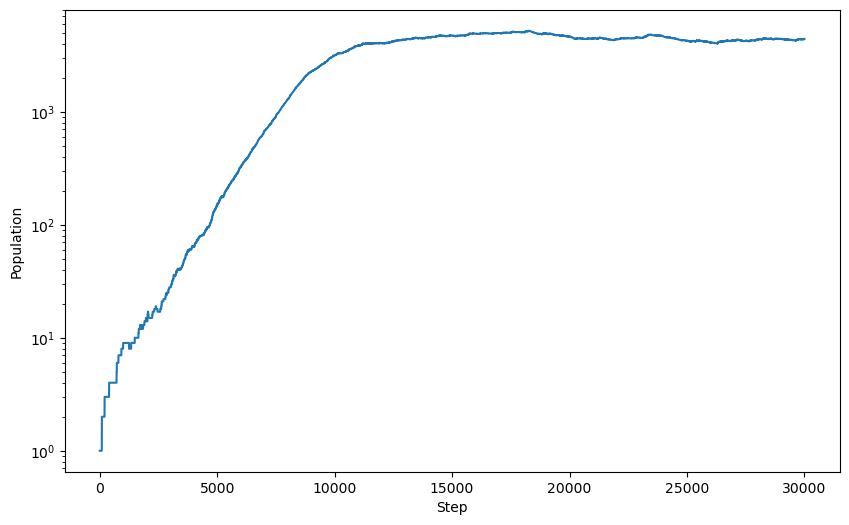

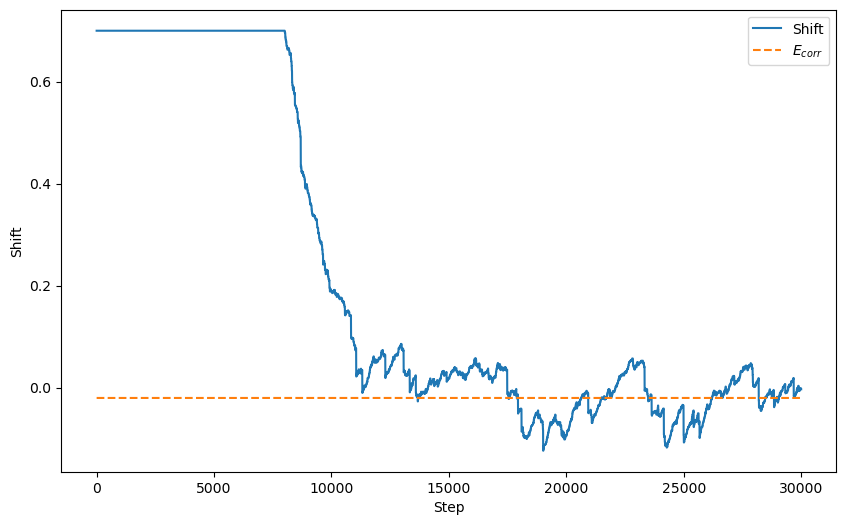

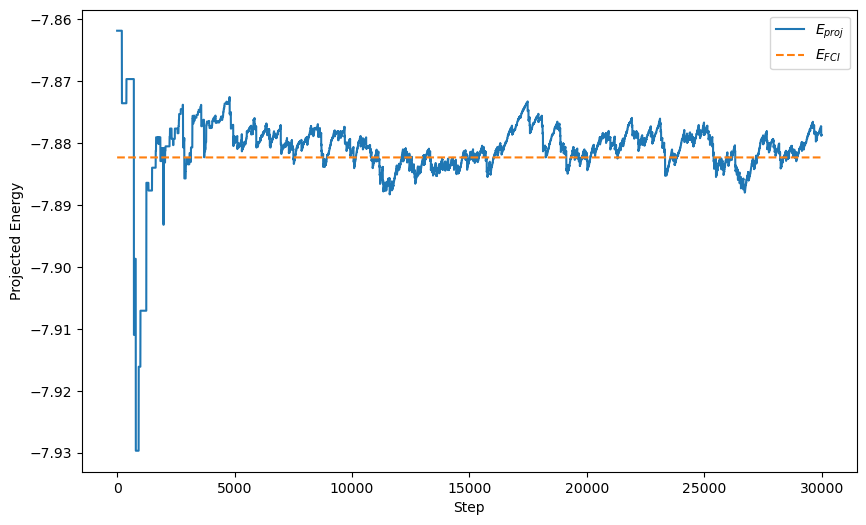

In [120]:
from pyscf import gto

# LiH分子の定義
mol = gto.M(
    atom=f"Li 0 0 0; H 0 0 1.6",
    basis="sto-3g",
    spin=0,      # singlet
    verbose=0
)
E_est, E_sd, E_fci, E_HF, avg_shift, hist_population, hist_shift, hist_energy = \
    FCIQMC(mol, shift=0.7, n_steps=30000, n_prod=10000, step_starting_shift_upd=8000)

# 結果を出力
print("-" * 30)
print(f"FCI Energy: {E_fci:.6f} Ha")
print(f"Final FCIQMC Energy: {E_est:.6f} ± {E_sd: .6f} Ha")
print(f"Average shift: {avg_shift:.6f} Ha => Energy: {avg_shift + E_HF}")
plot_result(E_fci, E_HF, hist_population, hist_shift, hist_energy)


## ${LiH}$ 分子 STO-3G, ステップ数ごとの標準偏差の確認
ステップ数を増やすと非常に実行に時間がかかる。

--- FCI Matrix ---
(225, 225)
[[-7.86186477e+00  1.27143163e-08 -1.26874419e-10 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 1.27143163e-08 -7.70892352e+00 -1.12113377e-02 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [-1.26874419e-10 -1.12113377e-02 -5.80885774e+00 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 ...
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ... -1.46233425e+00
   2.32707975e-17  1.17307897e-17]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  2.32707975e-17
  -1.41526201e+00  3.89084695e-17]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  1.17307897e-17
   3.89084695e-17 -1.38152373e+00]]
--- K Matrix ---
[[-3.55271368e-15  1.27143163e-08 -1.26874419e-10 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 1.27143163e-08  1.52941253e-01 -1.12113377e-02 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [-1.26874419e-10 -1.12113377e-02  2.05300703e+00 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 .

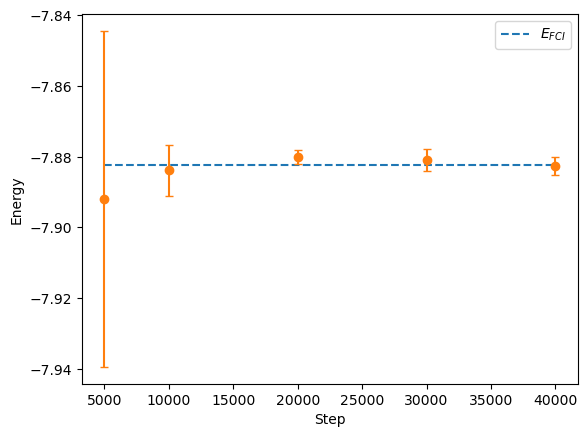

In [121]:
from pyscf import gto

n_steps_arr = [5000, 10000, 20000, 30000, 40000]

# LiH分子の定義
mol = gto.M(
    atom=f"Li 0 0 0; H 0 0 1.6",
    basis="sto-3g",
    spin=0,      # singlet
    verbose=0
)

E = []
sd = []

for n_steps in n_steps_arr:
    E_est, E_sd, E_fci, E_HF, avg_shift, hist_population, hist_shift, hist_energy = \
        FCIQMC(mol, shift=0.7, init_n_walker=1, n_steps=n_steps, n_prod=n_steps//4, step_starting_shift_upd=n_steps//4, debug=False)
    E.append(E_est)
    sd.append(E_sd)

E_fci_arr = np.full_like(n_steps_arr, E_fci, dtype=float)
plt.plot(n_steps_arr, E_fci_arr, linestyle="--", label=r"${E_{FCI}}$")
plt.errorbar(n_steps_arr, E, yerr=sd, fmt='o', capsize=3)
plt.xlabel('Step')
plt.ylabel('Energy')
plt.legend()
plt.show()

## ${N_2}$ at equilibrium
FCI行列が巨大過ぎて生成出来ない。必要な成分のみ取ってくる実装（on the fly?）に変える必要がありそう

In [ ]:
from pyscf import gto

# N2 at equilibriumの定義
R_bohr = 2.068     # a0
R_ang = R_bohr * 0.529177

mol = gto.M(
    atom=f"N 0 0 0; N 0 0 {R_ang}",
    basis="cc-pVDZ",
    unit="Angstrom",
    spin=0,      # singlet
    verbose=0
)
E_est, E_fci, E_HF, hist_population, hist_shift, hist_energy = \
    FCIQMC(mol, n_steps=1000, n_prod=500, step_starting_shift_upd=100)

# 結果を出力
print("-" * 30)
print(f"FCI Energy: {E_fci:.6f} Ha")
print(f"Final FCIQMC Energy: {E_est:.6f} Ha")
plot_result(E_fci, E_HF, hist_population, hist_shift, hist_energy)
